# Reproduce results on CIFAR-10

This notebook reproduces the results obtained on CIFAR-10 for:
* Linear probing with trained model on CIFAR-10-Alt
* Fine-tuned model on CIFAR-10 originally trained on CIFAR-10-Alt

**Note: performing model training and inference on a GPU will lead to significant speedups.**

## Required Imports

In [1]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.manifold import TSNE

from easy_icd.utils.datasets import create_dataset
from easy_icd.utils.augmentation import RandomImageAugmenter
from easy_icd.utils.models import ResNet
from easy_icd.training.train_models import train_model
from easy_icd.outlier_detection.detect_outliers import analyze_data
from easy_icd.outlier_removal.remove_outliers import remove_outliers

In [220]:
import gc

gc.collect()

torch.cuda.empty_cache()

## Create dataset

In [283]:
import torchvision

batch_size = 128
test_batch_size = 128

cif_10_train_data = torchvision.datasets.CIFAR10('./images/cifar_10', True, transforms.ToTensor(), None, False)
cif_10_test_data = torchvision.datasets.CIFAR10('./images/cifar_10', False, transforms.ToTensor(), None, False)

cif_train_dataloader = DataLoader(cif_10_train_data, batch_size=batch_size, shuffle=True)
cif_test_dataloader = DataLoader(cif_10_test_data, batch_size=test_batch_size, shuffle=True)

dataset_means_and_stds = [[0.4923, 0.4834, 0.4483], [0.2468, 0.2435, 0.2616]]

probs = 0.2 * torch.ones(8)
augmenter = RandomImageAugmenter((32, 32), probs, 2)

## Build linear classifier

In [294]:
model = ResNet(num_layers=3, num_blocks=[5, 5, 5], out_channels=[16 * (2 ** i) for i in range(4)],
               linear_sizes=[128, 64, 10], supervised=True)

model.load_state_dict(torch.load('./cifar_10_alt_cleaned/model_state_epoch_100.pt'))

linear_model = LinearClassifier(model, 64, 10)
linear_model.finetune(False)

128 128
128 64
Linear(in_features=64, out_features=10, bias=True)


## Train linear classifier

In [295]:
train_model(linear_model, cif_train_dataloader, cif_test_dataloader, './models/supervised/cifar_10_linear/',
            augmenter, 'ce', 30, None, 2, 0.1, lr=5e-3, min_lr=1e-3, num_warmup_epochs=10,
            losses_name='', gpu=True, dataset_means_and_stds=dataset_means_and_stds)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1
Batch:    1 | Loss:   2.27379 | Test loss:   2.32417 | Acc:   0.10547 | Test acc:   0.11484
Batch:   11 | Loss:   2.16206 | Test loss:   2.06908 | Acc:   0.21094 | Test acc:   0.24063
Batch:   21 | Loss:   1.86515 | Test loss:   1.78651 | Acc:   0.41406 | Test acc:   0.43984
Batch:   31 | Loss:   1.75454 | Test loss:   1.57908 | Acc:   0.48047 | Test acc:   0.55000
Batch:   41 | Loss:   1.43675 | Test loss:   1.32952 | Acc:   0.61719 | Test acc:   0.66641
Batch:   51 | Loss:   1.27538 | Test loss:   1.28062 | Acc:   0.67969 | Test acc:   0.65859
Batch:   61 | Loss:   1.24137 | Test loss:   1.14718 | Acc:   0.69141 | Test acc:   0.70312
Batch:   71 | Loss:   1.12462 | Test loss:   1.03733 | Acc:   0.74609 | Test acc:   0.74062
Batch:   81 | Loss:   1.17105 | Test loss:   1.00828 | Acc:   0.64844 | Test acc:   0.73750
Batch:   91 | Loss:   1.30659 | Test loss:   0.96850 | Acc:   0.60156 | Test acc:   0.74609
Batch:  101 | Loss:   

## Fine-tune model

In [296]:
linear_model.finetune(True)

In [ ]:
model.train()

train_model(linear_model, cif_train_dataloader, cif_test_dataloader, './cifar_10_ft/', augmenter, 'ce',
            100, None, 2, 0.1, lr=5e-3, min_lr=5e-4, num_warmup_epochs=25, losses_name='',
            gpu=True, dataset_means_and_stds=dataset_means_and_stds, epoch_offset=0)

Adjusting learning rate of group 0 to 5.0000e-04.
Epoch 1
Batch:    1 | Loss:   0.81650 | Test loss:   0.61843 | Acc:   0.66797 | Test acc:   0.78047
Batch:   11 | Loss:   0.82798 | Test loss:   0.55370 | Acc:   0.72266 | Test acc:   0.81250
Batch:   21 | Loss:   0.85121 | Test loss:   0.63937 | Acc:   0.69141 | Test acc:   0.77266
Batch:   31 | Loss:   0.81790 | Test loss:   0.61556 | Acc:   0.74219 | Test acc:   0.78906
Batch:   41 | Loss:   0.67450 | Test loss:   0.65509 | Acc:   0.77734 | Test acc:   0.77578
Batch:   51 | Loss:   0.70748 | Test loss:   0.61272 | Acc:   0.79688 | Test acc:   0.80234
Batch:   61 | Loss:   0.88232 | Test loss:   0.63273 | Acc:   0.67969 | Test acc:   0.78438
Batch:   71 | Loss:   0.73824 | Test loss:   0.65545 | Acc:   0.75781 | Test acc:   0.77500
Batch:   81 | Loss:   0.94025 | Test loss:   0.61382 | Acc:   0.67188 | Test acc:   0.78828
Batch:   91 | Loss:   0.69136 | Test loss:   0.60955 | Acc:   0.74609 | Test acc:   0.79375
Batch:  101 | Loss:   

## View learned representations

In [302]:
model = ResNet(num_layers=3, num_blocks=[5, 5, 5], out_channels=[16 * (2 ** i) for i in range(4)],
               linear_sizes=[128, 64, 10], supervised=True)

model.load_state_dict(torch.load('./cifar_10_alt_cleaned/model_state_epoch_100.pt'))

128 128
128 64
Linear(in_features=64, out_features=10, bias=True)


<All keys matched successfully>

In [305]:
from torchvision.transforms import Normalize

model.to('cuda')
model.eval()

normalizer = Normalize([0.4923, 0.4834, 0.4483], [0.2468, 0.2435, 0.2616])

feats_list = []
labels_list = []

num_batches = 50

for idx, (images, labels) in enumerate(cif_train_dataloader):
    images = normalizer(images).to('cuda')
    labels_list.append(labels.detach().numpy())
    
    features = model(images).cpu().detach()
    features = torch.div(features, torch.linalg.norm(features, dim=1, keepdim=True))
    feats_list.append(features)
    
    if idx == (num_batches - 1):
        break
    
feats_list = np.concatenate(feats_list, 0)
labels = np.concatenate(labels_list, 0)

In [306]:
from sklearn.manifold import TSNE

small_feats = TSNE(n_components=2, perplexity=50).fit_transform(feats_list)

[]

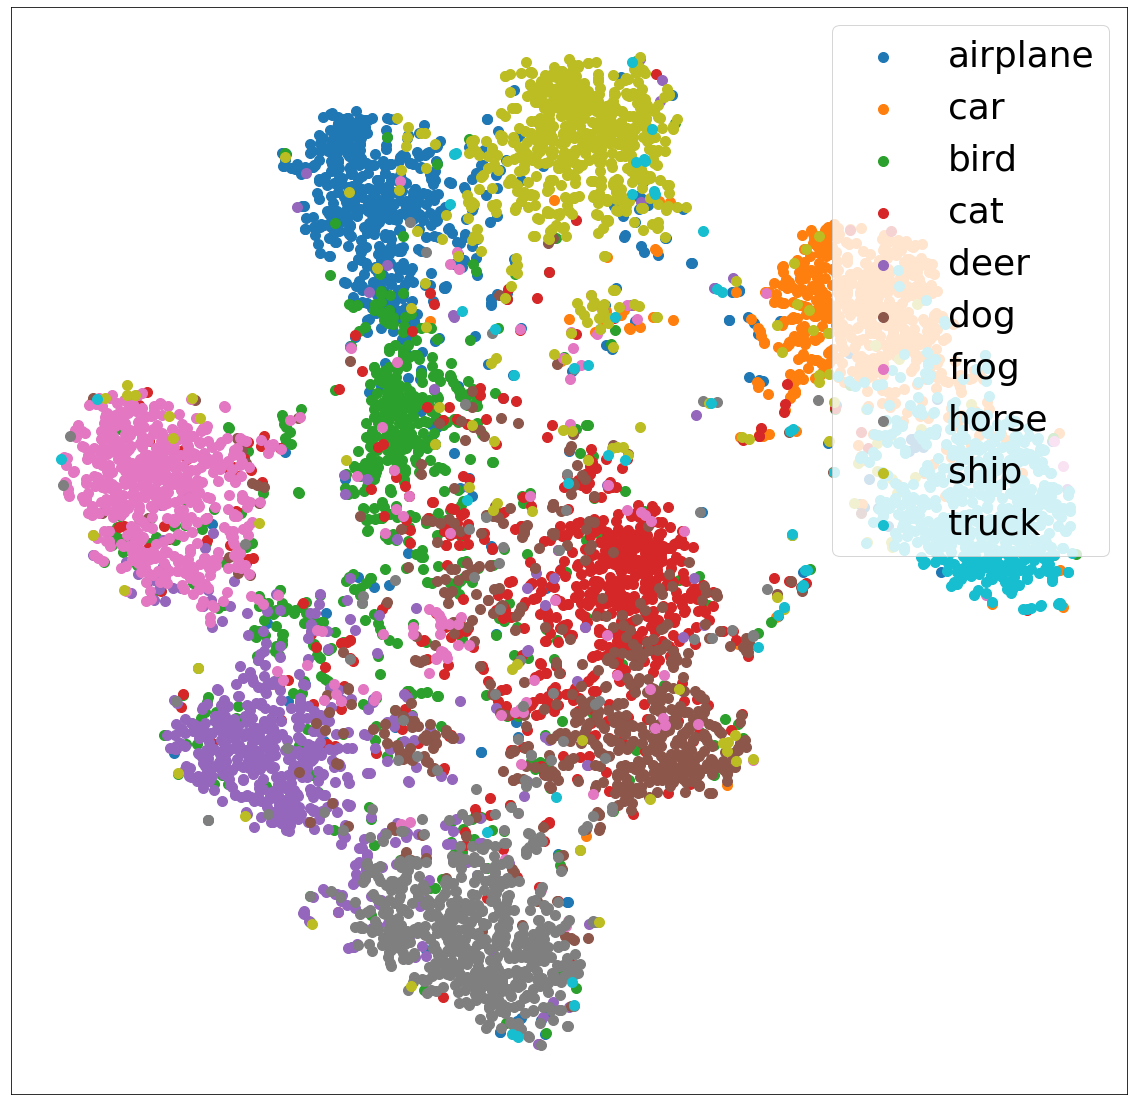

In [307]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

class_names = ['airplane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
# ax.scatter(small_feats[:7500, 0], small_feats[:7500, 1])
# ax.scatter(small_feats[7500:10000, 0], small_feats[7500:10000, 1])

# ax.scatter(small_feats[10000:17500, 0], small_feats[10000:17500, 1])
# ax.scatter(small_feats[17500:20000, 0], small_feats[17500:20000, 1])
for i in range(10):
    sel_inds = np.argwhere(labels == i).flatten()
    ax.scatter(small_feats[:, 0][sel_inds], small_feats[:, 1][sel_inds], label=class_names[i], s=100)
    
ax.legend(fontsize=36, ncol=1, loc=1)
ax.set_xticks([])
ax.set_yticks([])

## plot performance

In [343]:
model_dir = './cifar_10_ft'

num_epochs = 100

train_perf = open(model_dir + '/train_losses_.txt').read().split('\n')[:num_epochs]
test_perf = open(model_dir + '/test_losses_.txt').read().split('\n')[:num_epochs]

train_losses = [float(i.split('|')[0].split(':')[1]) for i in train_perf]
train_accs = [float(i.split('|')[1]) for i in train_perf]

test_losses = [float(i.split('|')[0].split(':')[1]) for i in test_perf]
test_accs = [float(i.split('|')[1]) for i in test_perf]

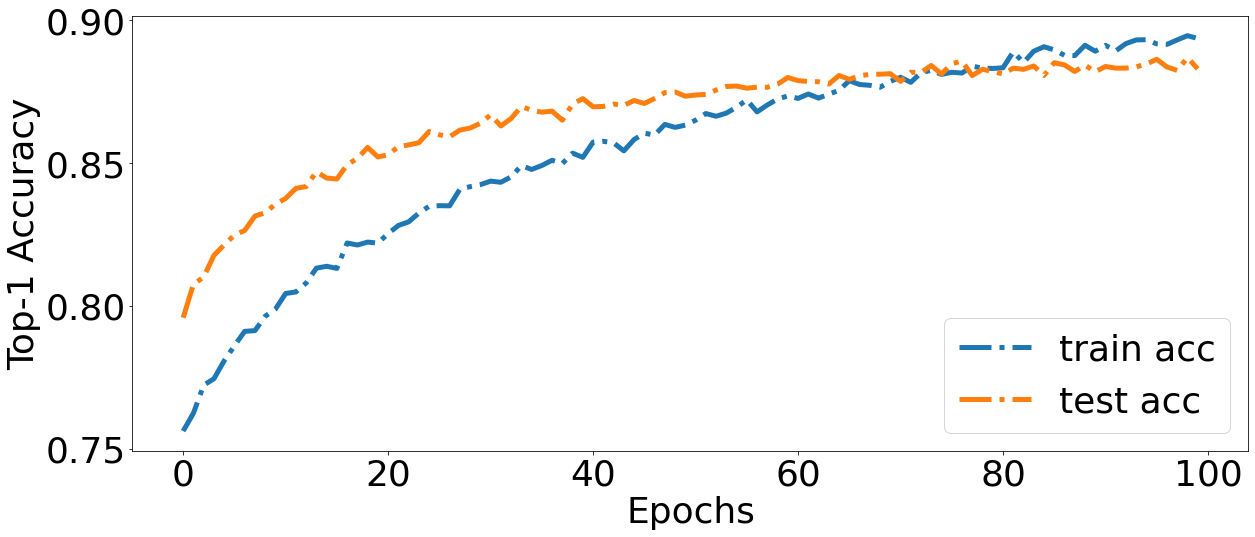

In [344]:
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

fsize = 36

plt.rc('font', size=fsize)
plt.rc('axes', labelsize=fsize)
plt.rc('xtick', labelsize=fsize)
plt.rc('ytick', labelsize=fsize)

# ax.plot(np.arange(num_epochs), train_losses, label='train loss', c='tab:blue', linewidth=5)
# ax.plot(np.arange(num_epochs), test_losses, label='test loss', c='tab:orange', linewidth=5)

ax.plot(np.arange(num_epochs), train_accs, label='train acc', c='tab:blue', linestyle='-.', linewidth=5)
ax.plot(np.arange(num_epochs), test_accs, label='test acc', c='tab:orange', linestyle='-.', linewidth=5)

# ax.set_ylabel('Cross-entropy loss', fontsize=36)
ax.set_ylabel('Top-1 Accuracy', fontsize=36)

ax.set_xlabel('Epochs', fontsize=36)

ax.legend(fontsize=36)
